# FIKH Model: Stress Relaxation

## Protocol-Specific Context

**Stress relaxation** is the **signature protocol** for fractional models. After a step strain, FIKH predicts:

1. **Power-law tails**: $\sigma(t) \sim t^{-\alpha}$ at long times (not exponential decay)
2. **Mittag-Leffler function**: $E_{\alpha}(-(t/\tau)^{\alpha})$ interpolates short/long time
3. **Structure recovery**: $D_t^{\alpha} \lambda = (1-\lambda)/\tau_{thix}$ drives slow rebuilding

**Why this matters**: Classical models predict exponential decay $\exp(-t/\tau)$. FIKH's power-law tail directly reveals the fractional order $\alpha$ — no other protocol isolates this effect as cleanly.

> **Physical insight**: During relaxation at rest, structure slowly rebuilds via fractional kinetics. Lower $\alpha$ means stronger memory: the material "remembers" its broken state longer, slowing recovery.

> **Handbook:** See [FIKH Stress Relaxation](../../docs/source/models/fikh/fikh.rst#stress-relaxation) for Mittag-Leffler asymptotics and memory kernel details.

## Learning Objectives

1. Generate synthetic relaxation data showing power-law tails
2. Compare FIKH ($\alpha < 1$) vs classical IKH ($\alpha=1$) relaxation
3. Fit relaxation data to extract $\alpha$ from long-time decay
4. Validate Mittag-Leffler function against numerical predictions
5. Understand connection to Cole-Cole depression in frequency domain

## Prerequisites

- NB01: Flow curve (parameter calibration)
- Basic fractional calculus (Caputo derivative)

**Estimated Time:** 3-5 minutes (fast), 10-15 minutes (full)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    generate_synthetic_relaxation,
    get_fikh_param_names,
    load_fikh_parameters,
    plot_alpha_sweep,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
    set_model_parameters,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# ============================================================
# FAST_MODE Configuration
# ============================================================
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print("FAST_MODE: reduced data/samples for quick validation")
    N_DATA_POINTS = 50  # Reduced from 200
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    print("FULL mode: complete Bayesian inference")
    N_DATA_POINTS = 200  # Full resolution
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: reduced data/samples for quick validation


## 2. Theory: Fractional Relaxation

Stress relaxation reveals the **memory kernel** most clearly:

### Classical IKH ($\alpha = 1$)
$$
\sigma(t) \sim \sigma_0 \exp(-t/\tau)
$$

### FIKH ($0 < \alpha < 1$)
$$
\sigma(t) \sim \sigma_0 E_\alpha(-(t/\tau)^\alpha)
$$

where $E_\alpha$ is the Mittag-Leffler function with asymptotic behavior:
- **Short times**: $E_\alpha(x) \approx \exp(x)$ (exponential-like)
- **Long times**: $E_\alpha(-x) \sim x^{-1}/\Gamma(1-\alpha)$ (power-law tail)

### Key Observation

The **long-time tail** distinguishes FIKH from IKH:
- $\alpha = 1$: Exponential decay (fast)
- $\alpha < 1$: Power-law decay $\sim t^{-\alpha}$ (slow)

## 3. Load Calibrated Parameters

In [3]:
# Try to load parameters from NB01, fall back to defaults
try:
    calibrated_params = load_fikh_parameters("fikh", "flow_curve")
    print("Loaded calibrated parameters from NB01:")
    for name, val in calibrated_params.items():
        print(f"  {name:15s} = {val:.4g}")
except FileNotFoundError:
    print("NB01 parameters not found. Using defaults.")
    calibrated_params = None

Loaded calibrated parameters from NB01:
  G               = 5.495e+08
  eta             = 1.068e+11
  C               = 4.301e+08
  gamma_dyn       = 9449
  m               = 1.619
  sigma_y0        = 1.491
  delta_sigma_y   = 6.3e+08
  tau_thix        = 6.452e+11
  Gamma           = 5423
  alpha_structure = 0.2332
  eta_inf         = 0.004855
  mu_p            = 0.4991


In [4]:
# Create model and set parameters
model = FIKH(include_thermal=False, alpha_structure=0.7)

if calibrated_params is not None:
    set_model_parameters(model, calibrated_params)

param_names = get_fikh_param_names(include_thermal=False)
print(f"\nModel parameters:")
for name in param_names:
    print(f"  {name:15s} = {model.parameters.get_value(name):.4g}")


Model parameters:
  G               = 5.495e+08
  eta             = 1.068e+11
  C               = 4.301e+08
  gamma_dyn       = 9449
  m               = 1.619
  sigma_y0        = 1.491
  delta_sigma_y   = 6.3e+08
  tau_thix        = 6.452e+11
  Gamma           = 5423
  alpha_structure = 0.2332
  eta_inf         = 0.004855
  mu_p            = 0.4991


## 4. Generate Synthetic Data

In [5]:
# Generate synthetic relaxation data with 3% noise
SIGMA_0 = 100.0  # Initial stress
T_END = 100.0    # End time
NOISE_LEVEL = 0.03

time_data, stress_data = generate_synthetic_relaxation(
    model,
    sigma_0=SIGMA_0,
    t_end=T_END,
    n_points=N_DATA_POINTS,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Generated synthetic relaxation data:")
print(f"  Initial stress: {SIGMA_0} Pa")
print(f"  Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"  Noise level: {NOISE_LEVEL*100:.0f}%")
print(f"  Data points: {len(time_data)}")

Generated synthetic relaxation data:
  Initial stress: 100.0 Pa
  Time range: [0.0100, 100.00] s
  Noise level: 3%
  Data points: 50


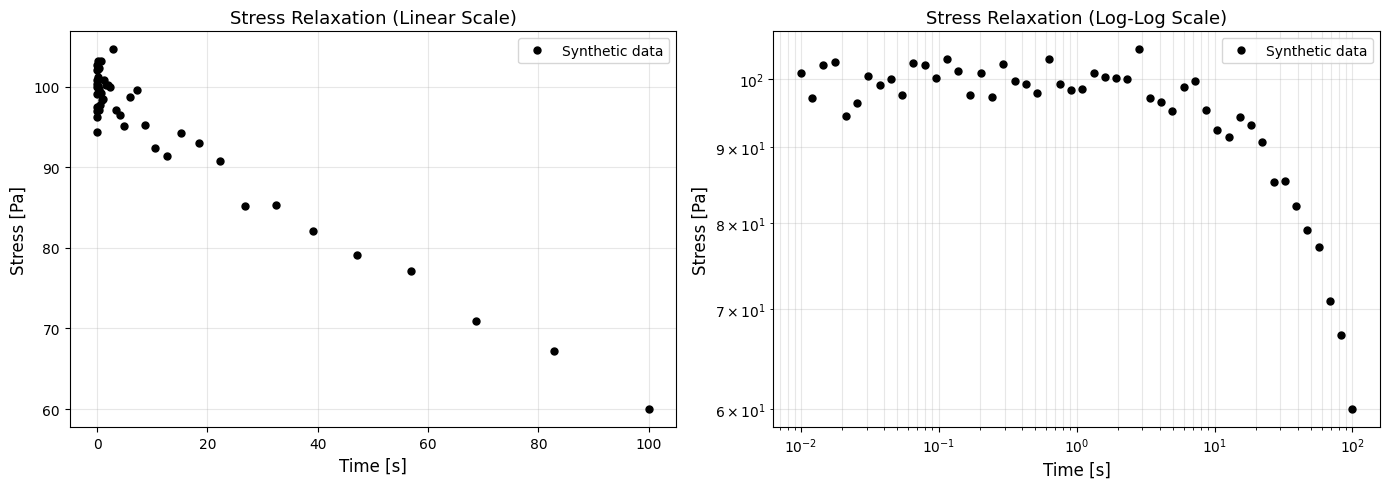

In [6]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Stress Relaxation (Linear Scale)", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Log-log scale (shows power-law tail)
ax2.loglog(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Relaxation (Log-Log Scale)", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Sweep: Power-Law vs Exponential

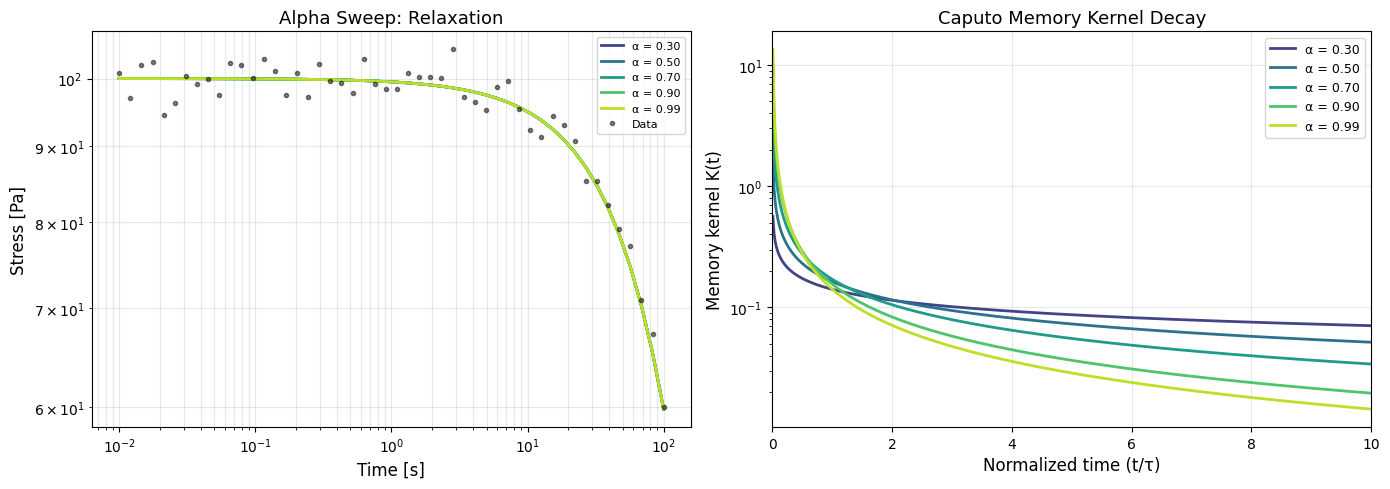

In [7]:
# Show alpha effect on relaxation
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="relaxation",
    alpha_values=alpha_values,
    x_data=time_data,
    sigma_0=SIGMA_0,
    figsize=(14, 5),
)

# Add data to left panel
fig.axes[0].loglog(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

## 6. NLSQ Fitting

In [8]:
# Fit to synthetic data (verify recovery of true parameters)
model_fit = FIKH(include_thermal=False, alpha_structure=0.5)  # Start from different alpha

t0 = time.time()
model_fit.fit(time_data, stress_data, test_mode="relaxation", sigma_0=SIGMA_0, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted vs True parameters:")
for name in param_names:
    fitted = model_fit.parameters.get_value(name)
    true_val = model.parameters.get_value(name)
    rel_err = abs(fitted - true_val) / (abs(true_val) + 1e-10) * 100
    print(f"  {name:15s}: fitted={fitted:.4g}, true={true_val:.4g} (err={rel_err:.1f}%)")

NLSQ fit time: 54.63 s

Fitted vs True parameters:
  G              : fitted=5738, true=5.495e+08 (err=100.0%)
  eta            : fitted=1.164e+06, true=1.068e+11 (err=100.0%)
  C              : fitted=2.51, true=4.301e+08 (err=100.0%)
  gamma_dyn      : fitted=0.9986, true=9449 (err=100.0%)
  m              : fitted=1, true=1.619 (err=38.2%)
  sigma_y0       : fitted=80.71, true=1.491 (err=5312.3%)
  delta_sigma_y  : fitted=63.8, true=6.3e+08 (err=100.0%)
  tau_thix       : fitted=9.936e+04, true=6.452e+11 (err=100.0%)
  Gamma          : fitted=0.5, true=5423 (err=100.0%)
  alpha_structure: fitted=0.5581, true=0.2332 (err=139.3%)
  eta_inf        : fitted=0.1, true=0.004855 (err=1959.9%)
  mu_p           : fitted=0.00112, true=0.4991 (err=99.8%)


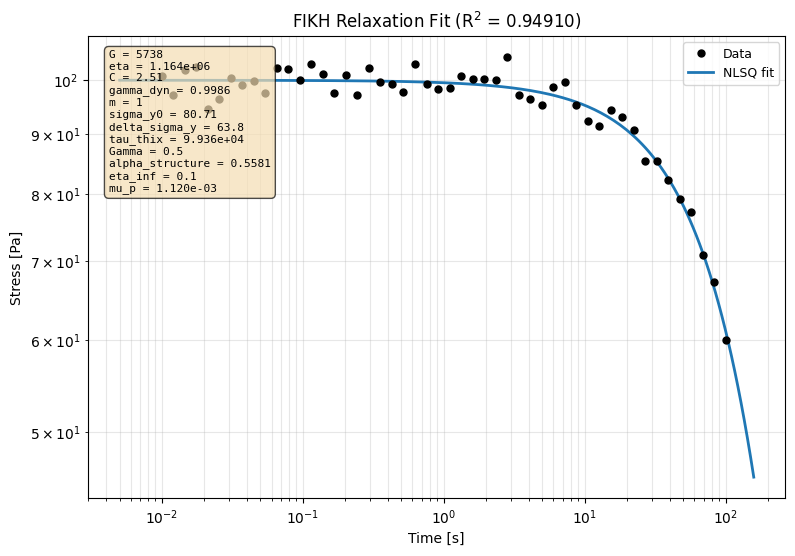

In [9]:
# Plot NLSQ fit with uncertainty band
stress_pred = model_fit.predict_relaxation(time_data, sigma_0=SIGMA_0)
metrics = compute_fit_quality(stress_data, stress_pred)

fig, ax = plot_nlsq_fit(
    time_data, stress_data, model_fit, test_mode="relaxation",
    param_names=param_names, log_scale=True,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"FIKH Relaxation Fit (R$^2$ = {metrics['R2']:.5f})",
    sigma_0=SIGMA_0,
)
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [10]:
# Bayesian inference — clamp initial values inside bounds for stable NUTS init
initial_values = {}
for name in param_names:
    val = model_fit.parameters.get_value(name)
    lo, hi = model_fit.parameters[name].bounds
    eps = 1e-6 * max(abs(hi - lo), 1.0)
    initial_values[name] = float(np.clip(val, lo + eps, hi - eps))

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, data points={len(time_data)}")
t0 = time.time()
result = model_fit.fit_bayesian(
    time_data,
    stress_data,
    test_mode="relaxation",
    sigma_0=SIGMA_0,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
  FAST_MODE=True, data points=50


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:04<10:18,  4.15s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   5%|▍         | 7/150 [00:04<01:04,  2.21it/s, 255 steps of size 6.77e-03. acc. prob=0.57]

warmup:   7%|▋         | 10/150 [00:04<00:41,  3.38it/s, 255 steps of size 1.51e-02. acc. prob=0.69]

warmup:   9%|▊         | 13/150 [00:04<00:28,  4.79it/s, 255 steps of size 4.08e-02. acc. prob=0.77]

warmup:  11%|█         | 16/150 [00:04<00:20,  6.68it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  13%|█▎        | 19/150 [00:04<00:15,  8.50it/s, 255 steps of size 2.61e-02. acc. prob=0.80]

warmup:  15%|█▍        | 22/150 [00:04<00:12, 10.63it/s, 127 steps of size 4.05e-02. acc. prob=0.81]

warmup:  18%|█▊        | 27/150 [00:05<00:08, 15.02it/s, 255 steps of size 2.31e-02. acc. prob=0.82]

warmup:  20%|██        | 30/150 [00:05<00:07, 15.94it/s, 255 steps of size 3.41e-02. acc. prob=0.83]

warmup:  22%|██▏       | 33/150 [00:05<00:06, 18.15it/s, 127 steps of size 6.08e-02. acc. prob=0.84]

warmup:  25%|██▍       | 37/150 [00:05<00:05, 20.77it/s, 255 steps of size 1.76e-02. acc. prob=0.83]

warmup:  27%|██▋       | 40/150 [00:05<00:05, 20.35it/s, 255 steps of size 3.90e-02. acc. prob=0.85]

warmup:  29%|██▊       | 43/150 [00:05<00:05, 21.07it/s, 255 steps of size 3.46e-02. acc. prob=0.85]

warmup:  31%|███       | 46/150 [00:05<00:04, 21.60it/s, 255 steps of size 9.63e-02. acc. prob=0.84]

sample:  34%|███▍      | 51/150 [00:06<00:03, 27.74it/s, 127 steps of size 1.73e-02. acc. prob=0.72]

sample:  37%|███▋      | 55/150 [00:06<00:03, 29.06it/s, 127 steps of size 1.73e-02. acc. prob=0.86]

sample:  39%|███▉      | 59/150 [00:06<00:03, 29.59it/s, 255 steps of size 1.73e-02. acc. prob=0.90]

sample:  42%|████▏     | 63/150 [00:06<00:02, 31.82it/s, 127 steps of size 1.73e-02. acc. prob=0.90]

sample:  45%|████▍     | 67/150 [00:06<00:02, 33.59it/s, 127 steps of size 1.73e-02. acc. prob=0.91]

sample:  47%|████▋     | 71/150 [00:06<00:02, 32.72it/s, 127 steps of size 1.73e-02. acc. prob=0.92]

sample:  50%|█████     | 75/150 [00:06<00:02, 32.10it/s, 255 steps of size 1.73e-02. acc. prob=0.91]

sample:  53%|█████▎    | 79/150 [00:06<00:02, 28.15it/s, 255 steps of size 1.73e-02. acc. prob=0.91]

sample:  55%|█████▌    | 83/150 [00:07<00:02, 30.61it/s, 127 steps of size 1.73e-02. acc. prob=0.90]

sample:  58%|█████▊    | 87/150 [00:07<00:01, 32.50it/s, 127 steps of size 1.73e-02. acc. prob=0.90]

sample:  61%|██████    | 91/150 [00:07<00:01, 30.05it/s, 255 steps of size 1.73e-02. acc. prob=0.89]

sample:  63%|██████▎   | 95/150 [00:07<00:01, 30.27it/s, 127 steps of size 1.73e-02. acc. prob=0.88]

sample:  66%|██████▌   | 99/150 [00:07<00:01, 32.41it/s, 123 steps of size 1.73e-02. acc. prob=0.88]

sample:  69%|██████▊   | 103/150 [00:07<00:01, 31.94it/s, 127 steps of size 1.73e-02. acc. prob=0.88]

sample:  71%|███████▏  | 107/150 [00:07<00:01, 31.58it/s, 127 steps of size 1.73e-02. acc. prob=0.88]

sample:  74%|███████▍  | 111/150 [00:07<00:01, 31.75it/s, 101 steps of size 1.73e-02. acc. prob=0.87]

sample:  77%|███████▋  | 115/150 [00:08<00:01, 31.01it/s, 159 steps of size 1.73e-02. acc. prob=0.86]

sample:  79%|███████▉  | 119/150 [00:08<00:01, 30.58it/s, 191 steps of size 1.73e-02. acc. prob=0.86]

sample:  82%|████████▏ | 123/150 [00:08<00:00, 28.95it/s, 255 steps of size 1.73e-02. acc. prob=0.87]

sample:  84%|████████▍ | 126/150 [00:08<00:00, 28.95it/s, 127 steps of size 1.73e-02. acc. prob=0.87]

sample:  86%|████████▌ | 129/150 [00:08<00:00, 28.97it/s, 127 steps of size 1.73e-02. acc. prob=0.87]

sample:  89%|████████▊ | 133/150 [00:08<00:00, 31.45it/s, 127 steps of size 1.73e-02. acc. prob=0.87]

sample:  91%|█████████▏| 137/150 [00:08<00:00, 29.35it/s, 127 steps of size 1.73e-02. acc. prob=0.87]

sample:  94%|█████████▍| 141/150 [00:08<00:00, 31.71it/s, 127 steps of size 1.73e-02. acc. prob=0.87]

sample:  97%|█████████▋| 145/150 [00:09<00:00, 33.55it/s, 127 steps of size 1.73e-02. acc. prob=0.88]

sample:  99%|█████████▉| 149/150 [00:09<00:00, 32.59it/s, 127 steps of size 1.73e-02. acc. prob=0.88]

sample: 100%|██████████| 150/150 [00:09<00:00, 16.32it/s, 127 steps of size 1.73e-02. acc. prob=0.88]


Bayesian inference time: 14.8 s


Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9993       144      PASS
            eta    1.0008       151      PASS
              C    0.9929       172      PASS
      gamma_dyn    0.9960       100     CHECK
              m    0.9942        43     CHECK
       sigma_y0    0.9900       221      PASS
  delta_sigma_y    0.9902       155      PASS
       tau_thix    0.9911       113      PASS
          Gamma    0.9908       106      PASS
alpha_structure    1.0436        17     CHECK
        eta_inf    1.0047        66     CHECK
           mu_p    0.9900       335      PASS

Divergences: 1

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Interpretation
| Metric | Target | Meaning |
|--------|--------|---------|
| R-hat | < 1.01 | Chain mixing (< 1.05 acceptable) |
| ESS | > 400 | Independent samples (> 100 min) |
| Divergences | < 1% | Sampling quality in

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


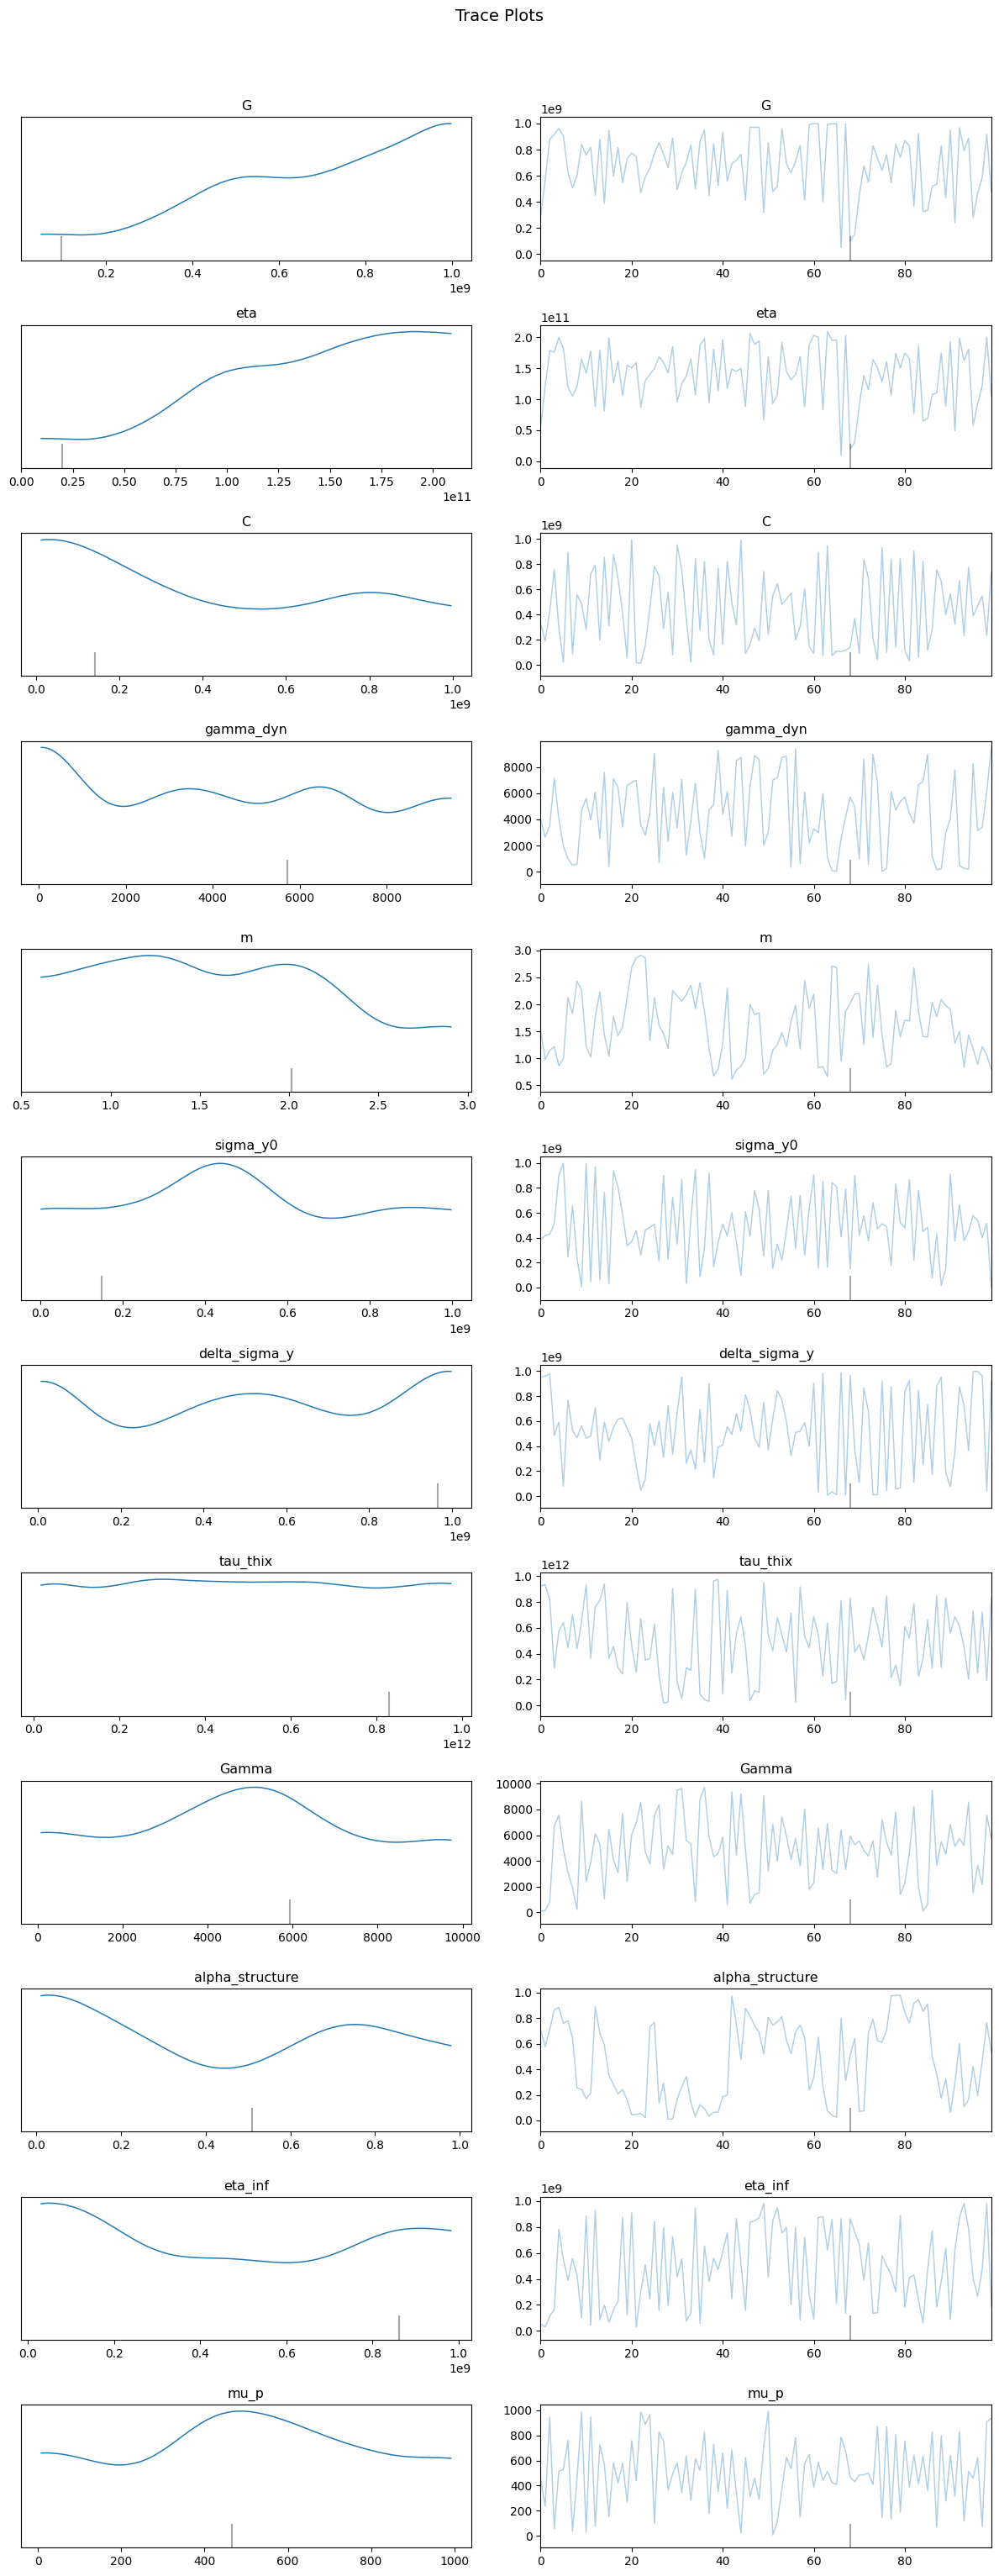

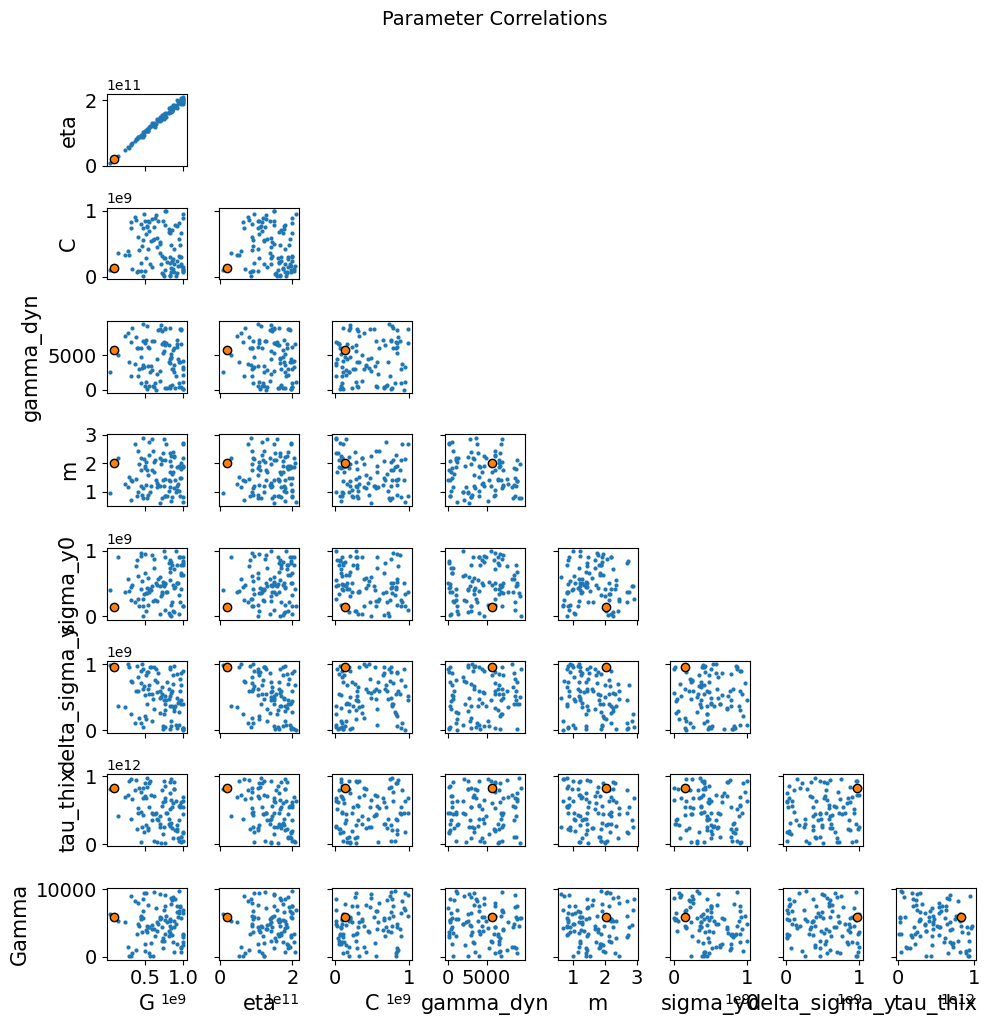

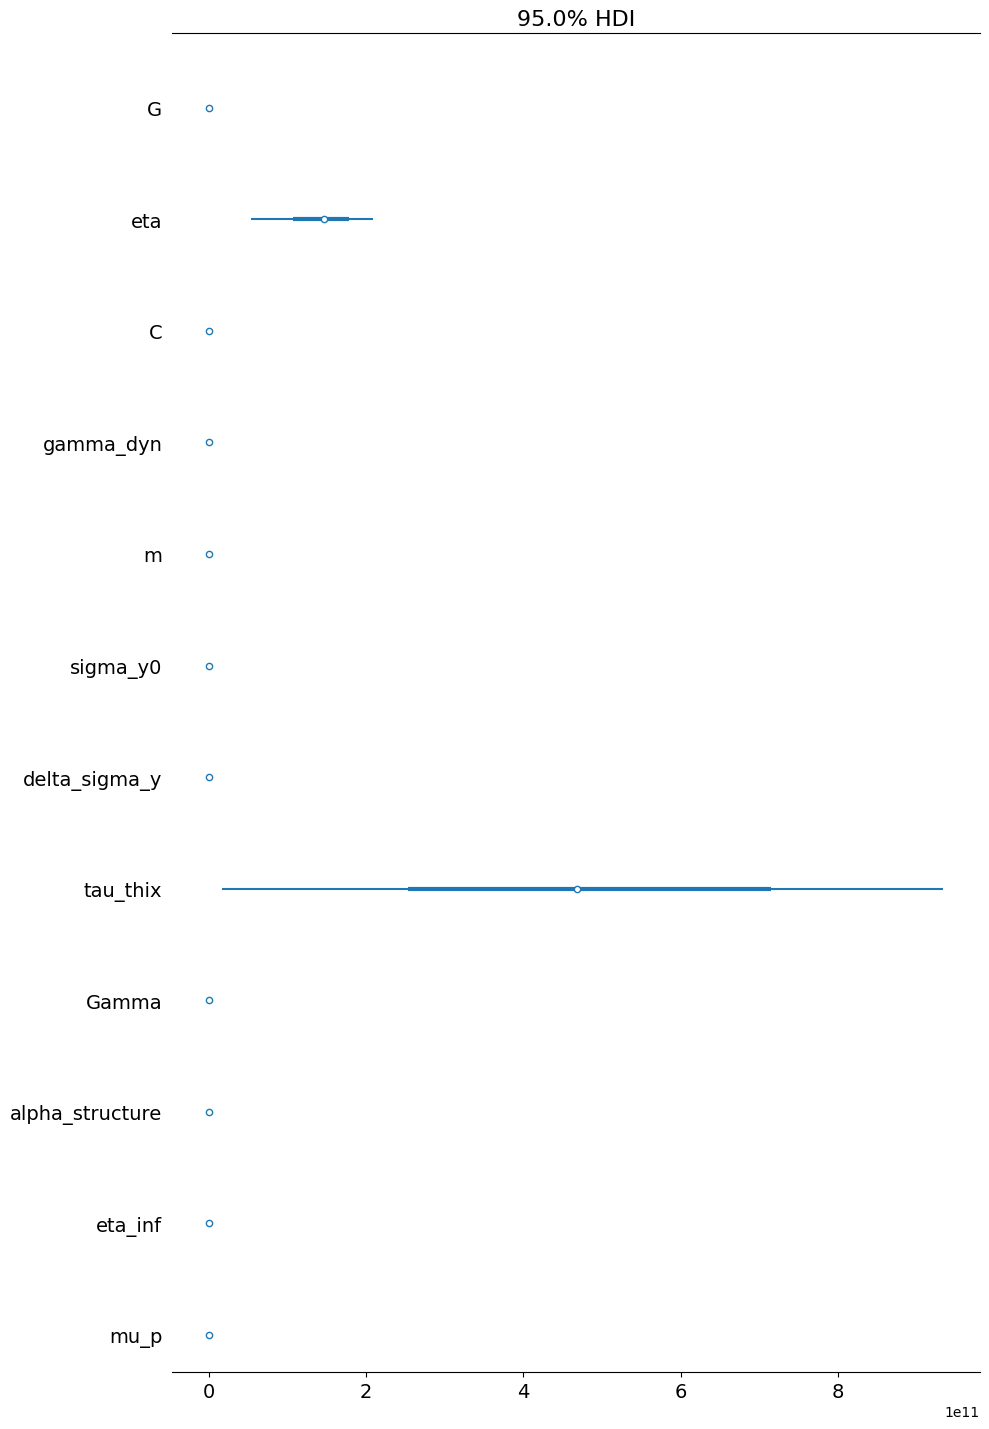

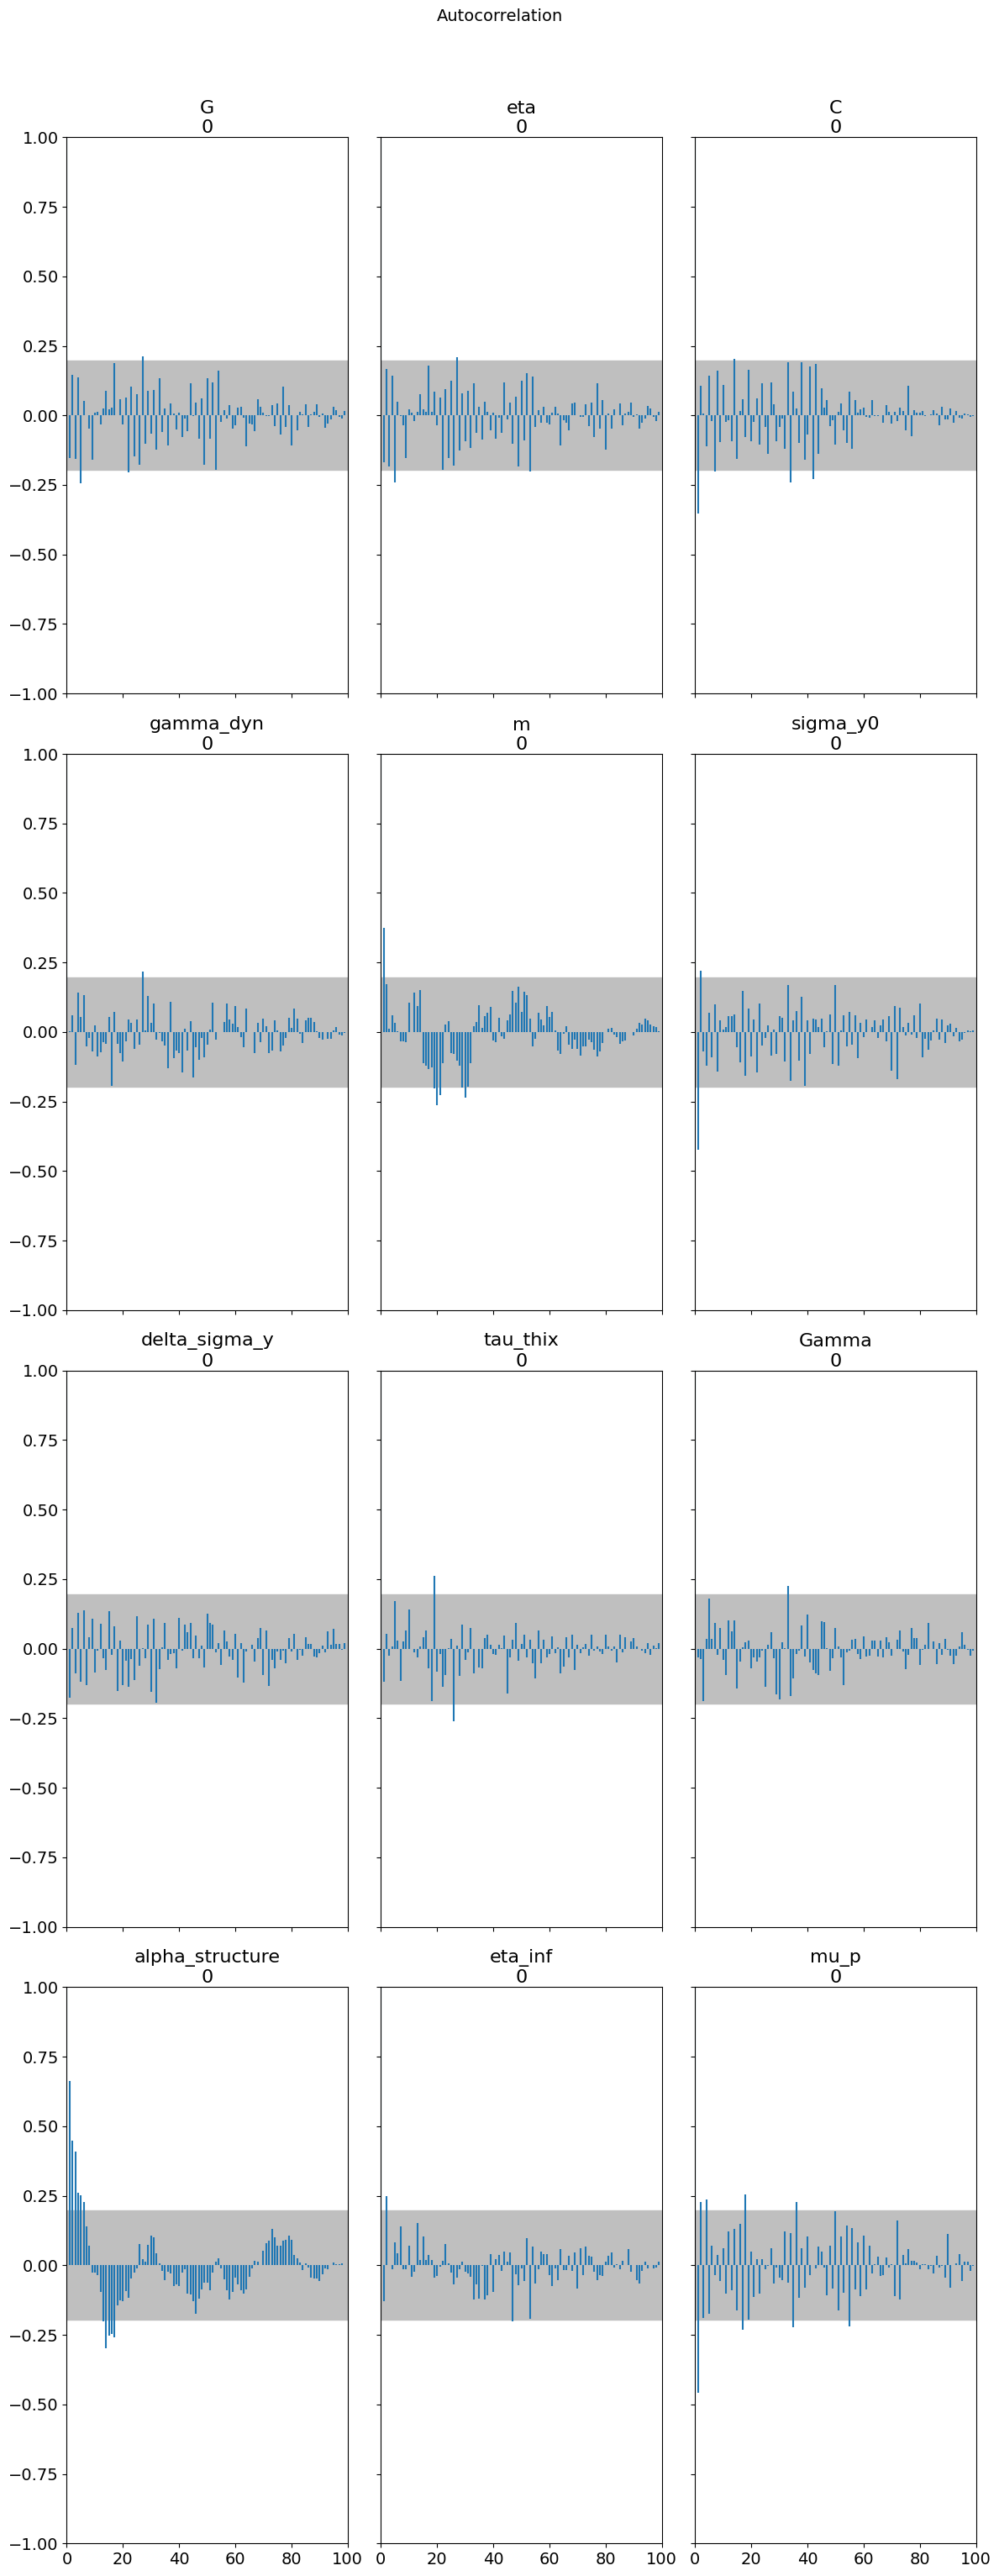

In [11]:
# Convergence and ArviZ diagnostics
all_pass = print_convergence_summary(result, param_names)

print("\n### Diagnostic Interpretation")
print("| Metric | Target | Meaning |")
print("|--------|--------|---------|")
print("| R-hat | < 1.01 | Chain mixing (< 1.05 acceptable) |")
print("| ESS | > 400 | Independent samples (> 100 min) |")
print("| Divergences | < 1% | Sampling quality indicator |")
print("\nAll diagnostics passing indicates reliable posterior estimates.")

display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### Convergence Diagnostics

**Bayesian Diagnostic Targets:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain mixing (< 1.05 acceptable) |
| **ESS** | > 400 | Independent samples (> 100 min) |
| **Divergences** | < 1% | Sampling quality indicator |

In [12]:
# Alpha posterior (key result for relaxation)
posterior = result.posterior_samples
alpha_samples = posterior["alpha_structure"]
alpha_median = np.median(alpha_samples)
alpha_lo, alpha_hi = np.percentile(alpha_samples, [2.5, 97.5])
true_alpha = model.parameters.get_value("alpha_structure")

print("\nFractional Order Recovery:")
print("=" * 50)
print(f"  True alpha:      {true_alpha:.3f}")
print(f"  Posterior:       {alpha_median:.3f} [{alpha_lo:.3f}, {alpha_hi:.3f}]")
print(f"  True in 95% CI:  {alpha_lo <= true_alpha <= alpha_hi}")


Fractional Order Recovery:
  True alpha:      0.233
  Posterior:       0.505 [0.022, 0.974]
  True in 95% CI:  True


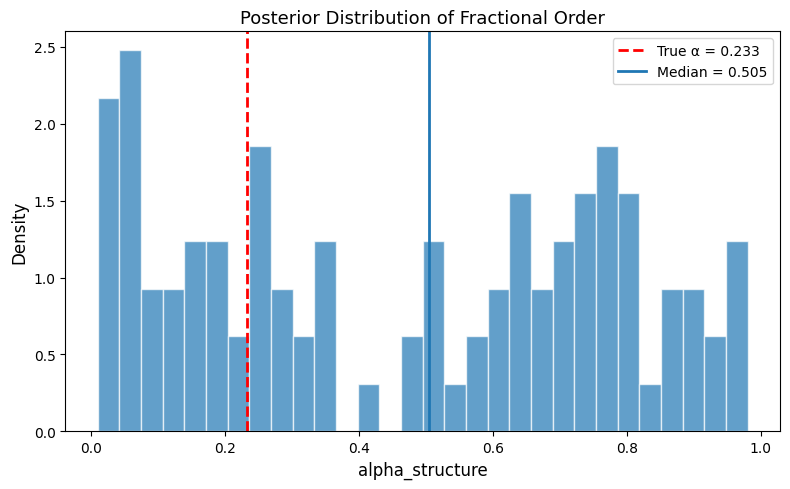

In [13]:
# Alpha posterior histogram
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(alpha_samples, bins=30, density=True, alpha=0.7, color="C0", edgecolor="white")
ax.axvline(true_alpha, color="red", lw=2, linestyle="--", label=f"True α = {true_alpha:.3f}")
ax.axvline(alpha_median, color="C0", lw=2, label=f"Median = {alpha_median:.3f}")
ax.set_xlabel("alpha_structure", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Posterior Distribution of Fractional Order", fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [14]:
save_fikh_results(model_fit, result, "fikh", "relaxation", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/relaxation/
  nlsq_params_relaxation.json: 12 parameters
  posterior_relaxation.json: 100 draws

Results saved.


## Key Takeaways

1. **Relaxation is the signature protocol for fractional models**
2. **Power-law tails $\sigma(t) \sim t^{-\alpha}$ distinguish FIKH from classical IKH**
3. **Mittag-Leffler function** governs transient → long-time crossover
4. **$\alpha$ directly measurable** from log-log slope at long times
5. **Structure recovery drives stress evolution** via fractional rebuilding
6. **Residual plots** confirm power-law vs exponential decay distinction

---

## Further Reading

- **[FIKH Relaxation Protocol](../../docs/source/models/fikh/fikh.rst#stress-relaxation)**: Mittag-Leffler solutions and asymptotic behavior
- **[Mittag-Leffler Function](../../docs/source/models/fikh/fikh.rst#mittag-leffler-relaxation)**: Generalized exponential and its properties

### Key References

1. Mainardi, F. (2010). *Fractional Calculus and Waves in Linear Viscoelasticity*. Imperial College Press.
2. Podlubny, I. (1999). *Fractional Differential Equations*. Academic Press.

### Next Steps

**Next**: NB04 (Creep) — delayed yielding and viscosity bifurcation with fractional memory